## TODO
* Re-write for more than two classes
* First fix FI, then FM
* Monte Carlo sim to test all permutations; OR:
* Increment steps based on PDF, with each step having an equal prob.
* Jim's suggestion: try replacing EM with land, in addition to water, as I have it now
* Add randomization/monte-carlo into bins- instead of just using mean values (i.e. for size bins, or for FLUX_STEP in senstivity)
* For typical EM fraction: use regional sub-binning instead of UAVSAR footprint 
* Use typical regional values for EM fluxes, the way I use a regional LSD and inun fraction
* install add-ons: git, variable inspector: first install node.js, npm, jupyterlab-git
* Find a plugin to make matplotlib plots interactive like when they appear in sep. window
* make dimensionless version
* (contour plot: fill in color between lines) DONE
* Add size binning: ingest lake size distrib DONE

## Description
This script takes as input the landscape inundation fraction, the emergent macrophyte fraction (fraction of all inundated areas), and flux values for these fractions. It then iterates over probable ranges and plots the total flux's sensitivities to these values, Normalized by area.


| Name  | Description | Value |
|---      |---                |---       |
| INPUTS |
FLUXES | Dictionary of flux values by class	<mg CH4 / m2/ day>| OW: (0, 166); EM: (77, 5800)
FRACTION:IN_TOTAL | Fraction inundated: Range for open water and emergent macrophyte area divided by total landscape area | (10, 38)
FRACTION:EM | Fraction EMERGENT macrophyte: Range for emergent macrophyte area / open water area | (2, 60)
FRACTION:  ... | ...
FRACTION_STEPS | Number of steps for each landcover type (range / increment) |
FLUX_STEPS | Number of steps for flux (range / increment) |


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
# %matplotlib inline

### Inputs

In [2]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(
    (22, 31),
    (10,16),
    (27, 30),
    (37.4, 37.6),
    (10, 37.6)), # Default Fraction Inundated; From Run 35
    'EM':((35, 58),
     (42, 60),
     (12, 21),
     (2, 2.5),
     (2, 60)) #(2, 30) # Default Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences | Superceded if using LSD
    'EM': (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
}
    # Sensitivity raster dimensions
FRACTION_STEPS=40
FLUX_STEPS=40
SITES=('PAD','YFB','YKN','DAR','All') #short names for sites
SITES_LSD = (9,2,7,7,0) # numbers as givin in Lake Size Distribution files
# REGION=0 # Set to -1 if using default; 0=PAD

# LAT=59 # latitude, in degrees (PAD=59)

### Lake size distribution inputs

Labels:
    'All'
    'Sagavanirktok River'
    'Yukon Flats Basin'
    'Old Crow Flats'
    'Mackenzie River Delta'
    'Mackenzie River Valley'
    'Canadian Shield Margin'
    'Canadian Shield'
    'Slave River'
    'Peace-Athabasca Delta'
    'Athabasca River'
    'Prairie Potholes North'
    'Prairie Potholes South'
    'Tuktoyaktuk Peninsula'
    []
    []
    []
    []
    []
    []
    []
    'Prairie pothole regions'
    'Canadian Shield'
    'Thermokarst regions'
    'Arctic-boreal wetlands'
    'Lowland river valleys'

In [3]:
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'

### Size binning data from Holgerson and Raymond 2016

In [4]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000000]) # <km2>
# BIN_EDGES=np.array([0.001, 0.01, 0.1, 1, 10, 100, 10000000]) * 1000000 # <km2> * 1000000 = <m2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [5]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [6]:
SENSITIVITY={}
FRACTION_POSTINGS={}
FLUX_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
        print(f'EM fraction: {FRACTION_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
            {lsd_vals.statistic[0]*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W area: \
            {np.sum(lsd_vals.statistic)*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = <region's inundation fraction> * (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY[s][i,j] = np.mean(FRACTION['IN_TOTAL'][si]) / 100 * (FRACTION_POSTINGS[s][i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62

EM fraction: 35.00%	| Total W area in first bin:             0.26	| Total W area:             121.30	| Total W flux: 0.89
EM fraction: 35.59%	| Total W area in first bin:             0.26	| Total W area:             120.20	| Total W flux: 0.88
EM fraction: 36.18%	| Total W area in first bin:             0.26	| Total W area:             119.10	| Total W flux: 0.87
EM fraction: 36.77%	| Total W area in first bin:             0.25	| Total W area:             118.00	| Total W flux: 0.86
EM fraction: 37.36%	| Total W area in first bin:             0.25	| Total W area:             116.90	| Total W flux: 0.85
EM fraction: 37.95%	| Total W area in first bin:             0.25	| Total W area:             115.80	| Total W flux: 0.85
EM fraction: 38.54%	| Total W area in first bin:             0.25	| Total W area:             114.70	| Total W flux: 0.84


In [7]:
## SCRAP

FRACTION['EM'][si]
FLUXES

{'OW': (0, 166), 'EM': (77, 3000)}

In [8]:
## SCRATCH
i=1
    lsd-0.004
lsd_tmp=lsd*(100-FRACTION_POSTINGS[i])/100 # keeps decreasing in mag. each iteration as EM fraction grows
lsd
FLUX_POSTINGS['OW'][j]
FRACTION_POSTINGS
FLUX_POSTINGS['OW']
lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='count', bins=BIN_EDGES) # could also use np.digitize, for binned_stat, need to add min and max bins on either end and rightmost bin is basically ignored
# np.any(np.isin(lsd_tmp, np.nan))
# lsd_tmp
# BIN_FLUXES
lsd_tmp_vals.statistic.shape
BIN_EDGES
# lsd_tmp_vals.statistic
# BIN_FLUXES.shape
# lsd_tmp_vals.statistic
lsd_tmp_vals.statistic*BIN_FLUXES
np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd.sum()
# lsd_tmp.sum()
# np.sum(lsd_tmp >= BIN_EDGES[-2])
# BIN_EDGES[-2]
i=7
print(f'Bins: {BIN_EDGES}')
print(f'Number of lakes in alleged bin {i}: {np.sum((lsd_tmp > BIN_EDGES[i-1]) & (lsd_tmp <= BIN_EDGES[i]))}')
print(f'Number of lakes in statistic bins: {lsd_tmp_vals.statistic}')
np.max(lsd)
np.sum(lsd_tmp > BIN_EDGES[i])
i=39
(100-FRACTION_POSTINGS[i])/100
np.sum(lsd_vals.statistic)
lsd_vals.statistic
np.sum(lsd)*(100- 0)/100

IndentationError: unexpected indent (<ipython-input-8-94ddb254ca94>, line 3)

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.pdf


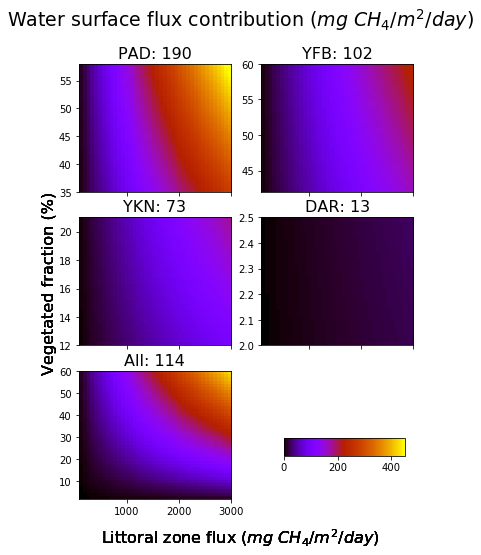

In [9]:
## Raster plot
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])
f=16 # font size
# ax=np.zeros((3,2))
shape=(3,2)
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
    p=ax[idx].imshow(SENSITIVITY[s], origin='lower', aspect='auto', cmap='gnuplot', vmin=0, vmax=450, extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax[idx].set(xlabel="Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ylabel='Vegetated fraction (%)', fontsize=f)
#     ax[idx].set_title('{} | Total flux ($mg\ CH_4 / m^2 /day$)'.format(s), fontsize=f)
    ax[idx].set_title(f'{s}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     ax[idx].colorbar()
#     fig.tight_layout()
#     axes=plt.gca()
    # plt.rcParams({'dpi':300})
    # axes.set_xlim(FLUXES['EM'])
    # axes.set_ylim(FRACTION['EM'])
    # plt.xticks(FLUX_POSTINGS[0:4:])
    # plt.yticks(FRACTION_POSTINGS[0:4:])

    ## calculate median:
    cy, cx = ndi.center_of_mass(SENSITIVITY[s])

    ## report mean value:
#     print('Mean flux: \t{:.1f} mg CH_4/m^2/day'.format(np.mean(SENSITIVITY[s])))
#     print('\'Median\' flux: \t{:.1f} mg CH_4/m^2/day'.format(SENSITIVITY[s][cy.astype(int),cx.astype(int)])) # only equal to median if each step size is of equal prob.
#     print('''\nINPUTS:
#     FRACTION:\t{}
#     FLUXES:\t\t{}
#     '''.format(FRACTION, FLUXES))

    # common plot options
fig.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f+3)
ax[shape[0]-1, shape[1]-1].axis('off')
# ax[shape[0]-1, shape[1]-1].colorbar()
cbaxes = fig.add_axes([0.6, 0.2, 0.28, 0.03]) 
fig.colorbar(p, cax=cbaxes, orientation='horizontal')
# fig.colorbar(p, ax=ax[shape[0]-1, shape[1]-1], orientation='horizontal')
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.pdf'
plt.savefig(figPth, dpi=200)
print('Saved fig to:\t{}'.format(figPth))

In [9]:
np.mean(SENSITIVITY[s])

113.76668318959445

In [10]:
ax.flat

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.jpg


<Figure size 432x288 with 0 Axes>

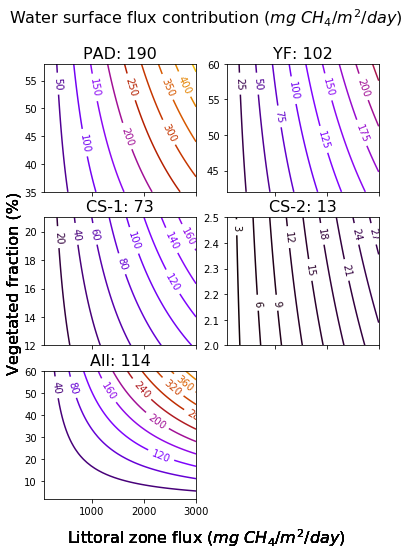

In [10]:
## Make contour plot
## TODO: fill in between lines
## from https://matplotlib.org/examples/pylab_examples/contour_label_demo.html

    # I/O
num_contours=10

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

##
plt.figure()

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax[idx].contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax[idx].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
    ax[idx].set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     plt.tight_layout()
    
    # plot format
plt.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f)
ax[shape[0]-1, shape[1]-1].axis('off')

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.pdf'
plt.savefig(figPth, dpi=200)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.jpg'
plt.savefig(figPth, dpi=200)
print('Saved fig to:\t{}'.format(figPth))

In [92]:
## Add fluxes from lit
lit_pth='data/Flux_synthesis.xlsx'
df=pd.read_excel(lit_pth)
df=df[~np.isnan( df['flux_to_plot_[mgCH4_m2_day]'])]

## fill empty vals
df['confidence_int_min_[mgCH4_m2_day]'][np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0)]=np.mean(df['confidence_int_min_[mgCH4_m2_day]'])
df['confidence_int_max_[mgCH4_m2_day]'][np.isin(df['confidence_int_max_[mgCH4_m2_day]'], 0)]=np.mean(df['confidence_int_max_[mgCH4_m2_day]'])
df['EM_percent'][np.isnan(df['EM_percent'])]=10 # arbitrary value, placeholder for now
df['conf_int_EM_percent']=5

## assign
FLUXES_LIT=df['flux_to_plot_[mgCH4_m2_day]'] # use for sens. plot
FRACTION_LIT=df['EM_percent'] # use for sens. plot
FRACTION_LIT_CI=df['conf_int_EM_percent']# use for sens. plot
FLUXES_LIT_CI=np.array([df['confidence_int_min_[mgCH4_m2_day]'], df['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot

## view
# df.head()
# df
df.describe()

,flux_to_plot_[mgCH4_m2_day],confidence_int_min_[mgCH4_m2_day],confidence_int_max_[mgCH4_m2_day],EM_percent,flux_to_plot_[mmolCH4_m2_day],confidence_int_min_[mmolCH4_m2_day],confidence_int_max_[mmolCH4_m2_day],conf_int_EM_percent
count,28.000000,28.000000,28.000000,28.000000,23.000000,20.000000,20.000000,28.0
mean,132.434965,71.736766,95.604821,18.214286,10.049565,4.869000,6.489000,5.0
std,254.287076,117.230771,160.640411,18.064406,17.014040,8.677389,11.893043,0.0
min,0.000000,0.160430,0.160430,10.000000,0.010000,0.010000,0.010000,5.0
25%,1.483977,6.336985,6.336985,10.000000,1.000000,0.350000,0.350000,5.0
50%,28.556540,55.795262,74.359305,10.000000,2.400000,0.550000,0.550000,5.0
75%,129.146150,60.696972,74.620004,10.000000,10.200000,6.900000,6.900000,5.0
max,1114.988500,537.440500,697.870500,60.000000,69.500000,33.500000,43.500000,5.0


In [93]:
# df[np.isnan(df['confidence_int_[mgCH4_m2_day]'])]
# df['confidence_int_[mgCH4_m2_day]']
# np.mean(df['confidence_int_[mgCH4_m2_day]'])
df[np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0)]
df[np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0)]['confidence_int_min_[mgCH4_m2_day]']
# df.loc[:, ([np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0)], df['confidence_int_min_[mgCH4_m2_day]'])]
df.loc[np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0), :]
np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0)
FLUXES_LIT_CI
FRACTION_LIT

27    10.0
28    10.0
29    10.0
30    60.0
31    10.0
32    10.0
33    10.0
34    10.0
35    60.0
36    60.0
37    10.0
38    10.0
39    10.0
40    10.0
41    10.0
42    10.0
58    10.0
59    10.0
60    10.0
61    10.0
62    10.0
63    10.0
64    10.0
65    10.0
66    10.0
67    50.0
68    50.0
69    10.0
Name: EM_percent, dtype: float64

In [94]:
## Single contour plot
%matplotlib widget
f=12
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
    plt.tight_layout()
    
## Superimpose errorbar plot
plt.errorbar(FLUXES_LIT, FRACTION_LIT, FRACTION_LIT_CI,FLUXES_LIT_CI[0])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ErrorbarContainer object of 3 artists>

In [42]:
SENSITIVITY

{'PAD': array([[  7.3764061 ,  14.32789969,  21.27939328, ..., 264.58166892,
         271.53316251, 278.4846561 ],
        [  7.49461425,  14.56323923,  21.63186421, ..., 269.03373864,
         276.10236362, 283.1709886 ],
        [  7.6128224 ,  14.79857877,  21.98433515, ..., 273.48580836,
         280.67156474, 287.85732111],
        ...,
        [ 11.75010764,  23.0354628 ,  34.32081796, ..., 429.3082486 ,
         440.59360376, 451.87895892],
        [ 11.86831579,  23.27080234,  34.6732889 , ..., 433.76031832,
         445.16280488, 456.56529143],
        [ 11.98652394,  23.50614189,  35.02575984, ..., 438.21238804,
         449.73200599, 461.25162394]]),
 'YFB': array([[  4.47010956,   8.56230956,  12.65450956, ..., 155.88150956,
         159.97370956, 164.06590956],
        [  4.51419357,   8.6513628 ,  12.78853203, ..., 157.58945511,
         161.72662434, 165.86379357],
        [  4.55827758,   8.74041604,  12.9225545 , ..., 159.29740066,
         163.47953912, 167.66167758],

In [524]:
FRACTION_POSTINGS

{'All': array([ 2.        ,  3.48717949,  4.97435897,  6.46153846,  7.94871795,
         9.43589744, 10.92307692, 12.41025641, 13.8974359 , 15.38461538,
        16.87179487, 18.35897436, 19.84615385, 21.33333333, 22.82051282,
        24.30769231, 25.79487179, 27.28205128, 28.76923077, 30.25641026,
        31.74358974, 33.23076923, 34.71794872, 36.20512821, 37.69230769,
        39.17948718, 40.66666667, 42.15384615, 43.64102564, 45.12820513,
        46.61538462, 48.1025641 , 49.58974359, 51.07692308, 52.56410256,
        54.05128205, 55.53846154, 57.02564103, 58.51282051, 60.        ])}

In [15]:
CS.levels

[0, 8, 16, 24, 32, 40, 48, 56]